# **Neural Networks - Deep Learning**
## Exercise 3 - Multiclass Classification using RBF Models

### Georgios Tsoumplekas, AEM: 9359

# **Part 0:** Laying the ground

## **Imports**

In [ ]:
import tensorflow as tf

from keras.datasets import mnist     
from keras.utils import np_utils  

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.manifold import TSNE, MDS

from scipy.spatial.distance import pdist

import numpy as np
import seaborn as sns
import random 
import time

import matplotlib.pyplot as plt

In [ ]:
!pip install imbalanced-learn

import imblearn
from imblearn.over_sampling import SMOTE 
print(imblearn.__version__)

0.8.1


## **Preprocesing of the MNIST dataset**

In [ ]:
#MNIST dataset parameters
num_classes = 10 #total classes: digits 0-9
num_features = 784 #data features (28x28 pixels image)

In [ ]:
#Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape", x_train.shape) 
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

#Convert to float32
x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)

#Flatten image to 1-D vector
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

#Normalize to [0,1]
x_train, x_test = x_train/255.0, x_test/255.0

#True output on the test set (needed to create confusion matrix later)
y_train_raw = y_train
y_test_raw = y_test

#One-hot encoding (to increase performance)
y_train, y_test = np_utils.to_categorical(y_train, num_classes), np_utils.to_categorical(y_test, num_classes)

11501568/11490434 [==============================] - 0s 0us/step
x_train shape (60000, 28, 28)
y_train shape (60000,)
x_test shape (10000, 28, 28)
y_test shape (10000,)


# **Part 1:** Data Visualization

In this part, we apply different dimensionality reduction techniques in order to visualize our data. Both linear (PCA) and non-linear (tSNE, MDS) techniques are used and the data are either visualized in 2D or 3D plots. The point of these techniques is to somehow preserve the structure between the points in the high-dimensional space to the low-dimensional space, too.

## 2-D Visualization using PCA

PCA is a linear dimensionality reduction technique and as a result when reducing dimensions, it tries to preserve the linear structure between the points in the new low-dimensional space.

PCA time elapsed: 2.551781415939331s
Explained variation per principal component: [0.09704716 0.07095958]


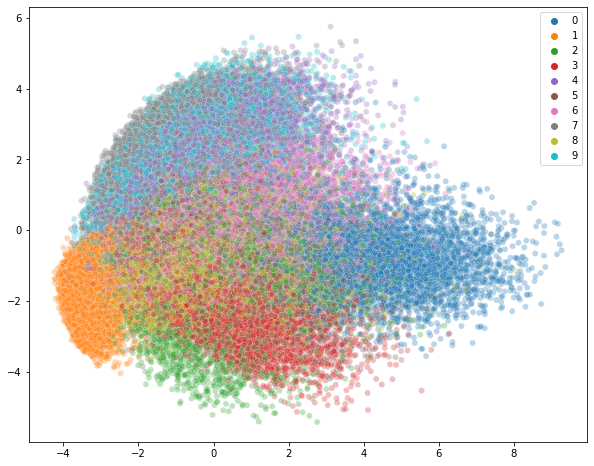

In [ ]:
# Apply PCA
start = time.time()
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)
end = time.time()
print('PCA time elapsed: {}s'.format(end-start))
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# Plot data
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=x_train_pca[:,0], y=x_train_pca[:,1] ,
    hue=y_train_raw,
    palette=sns.color_palette(),
    data=x_train_pca,
    legend="full",
    alpha=0.3
)

We can see that similar data (data with the same label) tend to lie closer to each other forming clusters. In some cases, these clusters are more discrete (for example label 1) while in other cases the bounds between them are not so clear (labels 9 and 4 for example). It is important to understand that when applying a dimensionality reduction from a space of 784 features to only 2, a lot of information is lost, but it's still a good way to get a picture of what labels might be easier or harder to classify correctly.

## 3-D Visualization using PCA

PCA time elapsed: 2.680569648742676s
Explained variation per principal component: [0.09704707 0.07095967 0.06169123]


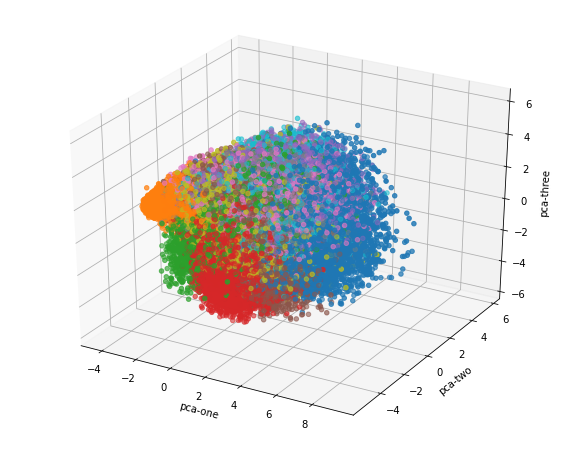

In [ ]:
# Apply PCA
start = time.time()
pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train)
end = time.time()
print('PCA time elapsed: {}s'.format(end-start))
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# Plot data
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=x_train_pca[:,0], 
    ys=x_train_pca[:,1], 
    zs=x_train_pca[:,2], 
    c=y_train_raw, 
    cmap='tab10',
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

When visualizing our data in a 3D space we can see that the different classes become a bit more discrete from each other now. That is because adding one more dimension means more variance that is being explained by the transformed data.

## 2-D Visualization using tSNE

tSNE is a non-linear dimensionality reduction technique that is commonly used when trying to visualize high-dimensional data. What tSNE does is that it tries to make more similar data neighbors and put dissimilar data further away. This is done by creating a probability distribution over pairs of data in the high dimensional space regarding their similarity, then doing the same in the low-dimensionality space and trying to make these distributions as similar as possible by minimizing their Kullback-Leibler divergence. As a result, tSNE preserves the topology (neighborhood structure).

PCA time elapsed: 7.265111207962036s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


t-SNE time elapsed: 568.994288444519s


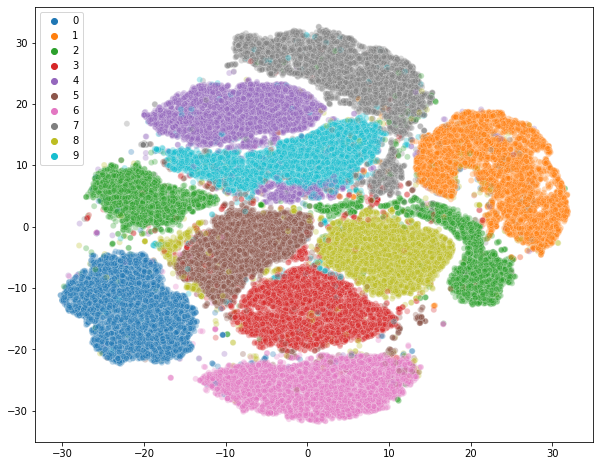

In [ ]:
# Apply PCA first to reduce number of dimensions
start = time.time()
pca = PCA(n_components=0.9).fit(x_train)
x_train_pca = pca.transform(x_train)
end = time.time()
print('PCA time elapsed: {}s'.format(end-start))

# Apply tSNE
start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500, n_iter_without_progress=50,
            early_exaggeration=40, learning_rate=500)
x_train_tSNE = tsne.fit_transform(x_train_pca)
end = time.time()
print('t-SNE time elapsed: {}s'.format(end-start))

# Plot data
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=x_train_tSNE[:,0], y=x_train_tSNE[:,1],
    hue=y_train_raw,
    palette=sns.color_palette(),
    data=x_train_tSNE,
    legend="full",
    alpha=0.3
)

Based on the parameters used, we can create more or less discrete clusters, that usually correspond to the actual labels. This plot is actually useful to see which data are more similar to each other. For example, data on the edge of the plot such as 0's are less similar to other numbers and as a result are easier to classify while 5's that are in the middle of the plot and have many neighboring classes are probably easier to misclassify. It is also worth noticing that some classes, like 2's for example are visualized as 2 different clusters meaning that not all 2's are similar to each other (2 subclasses of 2's).

## 2-D Visualization using MultiDimensional Scaling (MDS)

Multidimensional Scaling (MDS) is also a common non-linear technique used for dimensionality reduction. What MDS does is that it calculates the distance matrix in the initial high-dimensionality space and tries to create one in the low-dimensionality space that is as similar to the original as possible. This is done by minimizing an appropriate loss function using techniques such as stress majorization. As a result, MDS preserves the global geometry of the data in the original feature space.

MDS time elapsed: 2179.664808511734s


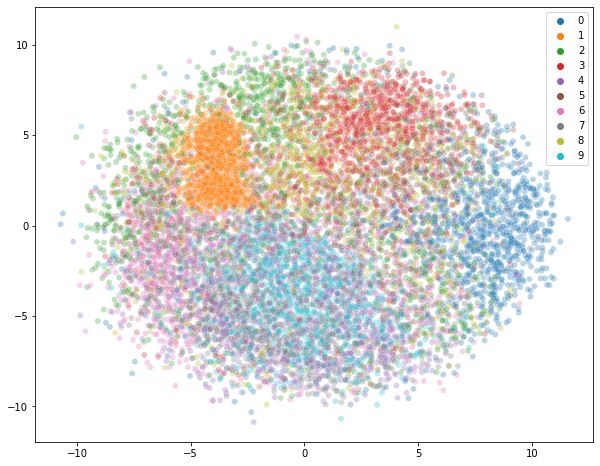

In [ ]:
# Apply MDS only for a subset of 10000 samples of the initial set
x_train_mini = x_train_pca[:10000,:]
y_train_raw_mini = y_train_raw[:10000]

# Apply MDS
start = time.time()
mds = MDS(n_components=2,metric=True,n_init=3,max_iter=250)
x_train_MDS = mds.fit_transform(x_train_mini)
end = time.time()
print('MDS time elapsed: {}s'.format(end-start))

# Plot data
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=x_train_MDS[:,0], y=x_train_MDS[:,1],
    hue=y_train_raw_mini,
    palette=sns.color_palette(),
    data=x_train_MDS,
    legend="full",
    alpha=0.3
)

For our case, we applied MDS only on 10000 samples of the original dataset. That was done because, MDS has to calculate the distance matrix of these samples and this consumes a lot of memory when done for a lot of samples (I run out of RAM when I tried it with more samples). As we can see, the classes are not so discrete form each other now, with the exception of label 1. This means that this technique is probably not as efficient as tSNE for example, in this particular dataset.

# **Part 2:** Trying out different RBFs

### Dimensionality reduction using PCA

In [ ]:
start = time.time()

pca = PCA(n_components=0.9).fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

end = time.time()
print("PCA elapsed time: {}s\n".format(end-start))
print("We extract {} feautures from the original {}.".format(x_train_pca.shape[1],x_train.shape[1]))
print('Cumulative explained variation for {} principal components: {}'.format(x_train_pca.shape[1], np.sum(pca.explained_variance_ratio_)))

PCA elapsed time: 6.237994194030762s

We extract 87 feautures from the original 784.
Cumulative explained variation for 87 principal components: 0.9001063108444214


Our goal was that the new components (features) achieve 90% explained variance of the initial ones. We see that by creating only 87 of them we can achieve this number (roughly 1/10th of the initial 784 features). 

### Define the base RBF model 

We use a hybrid technique for training the RBF model: \\
1) The centers of the Gaussian kernels in the hidden layer are found by applying the KMeans algorithm (number of centers defined by us). \\
2) The weights are found analytically. \\
As for the variance used in the gaussian kernels, this was calculated based on an heuristic found in the Haykin book.

In [ ]:
def RBF(num_centers, x_train, y_train, y_train_raw, x_test, y_test_raw, metrics=False):
    print("Number of centers: {}\n".format(num_centers))
    
    # Apply K-Means to find the centers of the kernels in the hidden layer
    start = time.time()
    kmeans = KMeans(n_clusters=num_centers, init='k-means++', n_init=10, verbose=0).fit(x_train)
    end = time.time()
    print("KMeans elapsed time: {}s".format(end-start))

    # Centers of the kernels
    centers = kmeans.cluster_centers_

    # Variance of each kernel
    dists = pdist(centers, metric='euclidean')
    d_max = np.amax(dists)
    var = d_max / tf.math.sqrt(2*float(centers.shape[0]))

    # Pass training data through the kernels
    start = time.time()
    x_train_kernel = rbf_kernel(x_train, Y=centers, gamma=np.float32(1/(2*var)))
    end = time.time()
    print("Transforming training data: {}s".format(end-start))
    
    # Calculate weights
    start = time.time()
    w = np.dot(np.linalg.pinv(x_train_kernel), y_train)
    end = time.time()
    print("Calculating weights: {}s".format(end-start))

    # Evaluate test set
    start = time.time()
    x_test_kernel = rbf_kernel(x_test, Y=centers, gamma=np.float32(1/(2*var)))
    y_pred_test = np.dot(x_test_kernel,w)
    y_pred_test = np.argmax(y_pred_test, 1)
    end = time.time()
    print("Testing elapsed time: {}s\n".format(end-start))

    # Evaluate training set
    y_pred_train = np.dot(x_train_kernel,w)
    y_pred_train = np.argmax(y_pred_train, 1)

    print('Training set accuracy: ', accuracy_score(y_train_raw,y_pred_train))
    print('Test set accuracy: ', accuracy_score(y_test_raw,y_pred_test))
    print('\n')
    
    if metrics is True:
        labels = [0,1,2,3,4,5,6,7,8,9]
        
        #Create and display confusion matrix
        M = confusion_matrix(y_test_raw, y_pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)

        disp.plot(cmap=plt.cm.Blues)
        plt.show

        #Accuracy, precision, recall and f1-score
        print(classification_report(y_test_raw, y_pred_test))

### Test RBF model for different number of centers

In [ ]:
# 10 centers
RBF(10,x_train_pca,y_train,y_train_raw,x_test_pca,y_test_raw)

# 100 centers
RBF(100,x_train_pca,y_train,y_train_raw,x_test_pca,y_test_raw)

# 1000 centers
RBF(1000,x_train_pca,y_train,y_train_raw,x_test_pca,y_test_raw)

# 2000 centers
RBF(2000,x_train_pca,y_train,y_train_raw,x_test_pca,y_test_raw)

Number of centers: 10

KMeans elapsed time: 12.616313457489014s
Transforming training data: 0.088714599609375s
Calculating weights: 0.04035806655883789s
Testing elapsed time: 0.017646074295043945s

Training set accuracy:  0.59495
Test set accuracy:  0.6036


Number of centers: 100

KMeans elapsed time: 129.01693391799927s
Transforming training data: 0.43311524391174316s
Calculating weights: 1.2796237468719482s
Testing elapsed time: 0.07662701606750488s

Training set accuracy:  0.86585
Test set accuracy:  0.877


Number of centers: 1000

KMeans elapsed time: 603.7263703346252s
Transforming training data: 4.180571556091309s
Calculating weights: 112.66286969184875s
Testing elapsed time: 0.8898501396179199s

Training set accuracy:  0.94175
Test set accuracy:  0.9385


Number of centers: 2000

KMeans elapsed time: 1166.5407800674438s
Transforming training data: 7.438968896865845s
Calculating weights: 556.08056807518s
Testing elapsed time: 1.4284498691558838s

Training set accuracy:  0.95086

As we can see, increasing the number of units in the hidden layer leads to the creation of better models, since accuracy is increasing in both training and test sets. It is clear that we could try a model with even more kernels, however this poses 2 problems: \\
1) The training time becomes extremely big (mostly due to the time needed for KMeans). \\
2) It is very memory-exhaustive calculate w for so many data points. \\
In part 4, we can see that we can tackle the second problem by using the Recursive Least Squares (RLS) algorithm, but in expense of extra training time.

# **Part 3:** Fine-Tuning of an RBF model

An important aspect of creating an appropriate model for a specific dataset, is to define the optimal hyper-parameters for it. In our RBF model the only hyperparameter that needs to be defined is the number of kernels in the hidden layer. \\
In order to find the optimal model we will apply grid search. Each of the candidate models will then be cross-validated using stratified 3-fold cross validation in order to achieve more robust estimations of the accuracy of each model. \\
Finaly, the model with the best accuracy is being chosen.

### Apply 3-fold cross-validation for each model to choose the optimal

In [ ]:
# 3-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True)

# Number of kernels in hidden layer
num_centers = np.array([100, 500, 1000, 2000])

acc_per_fold = np.zeros(3)
best_acc = -1.0
best_num_centers = None

model_no = 1

for i in num_centers:
    fold_no = 0  
    
    for train, test in kfold.split(x_train_pca, y_train_raw):
    
        # Centers of hidden layer
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, verbose=0).fit(x_train_pca[train])
        centers = kmeans.cluster_centers_

        # Variance for each kernel
        dists = pdist(centers, metric='euclidean')
        d_max = np.amax(dists)
        var = d_max / tf.math.sqrt(2*float(centers.shape[0]))

        # Pass training data through the kernels
        x_train_kernel = rbf_kernel(x_train_pca[train], Y=centers, gamma=np.float32(1/(2*var)))

        # Calculate weights
        w = np.dot(np.linalg.pinv(x_train_kernel), y_train[train])
        
        # Evaluate on test set
        x_test_kernel = rbf_kernel(x_train_pca[test], Y=centers, gamma=np.float32(1/(2*var)))
        y_pred_test = np.dot(x_test_kernel,w)
        y_pred_test = np.argmax(y_pred_test, 1)

        acc_per_fold[fold_no] = accuracy_score(y_train_raw[test],y_pred_test)

        fold_no += 1   

    # Mean of accuracy for 3-fold cross-validation of a specific model
    acc = np.mean(acc_per_fold)

    print('Model {}:'.format(model_no))
    print('Number of centers: ', i)
    print('Accuracy: ', acc)

    model_no += 1

    # Choose best model based on its accuracy
    if(acc > best_acc):
        best_acc = acc
        best_num_centers = i            
                          
print('Optimal parameters for the model:')
print('Number of centers: ', best_num_centers)
print('Accuracy: ', best_acc)

Model 1:
Number of centers:  100
Accuracy:  0.8679166666666666
Model 2:
Number of centers:  500
Accuracy:  0.9227666666666666
Model 3:
Number of centers:  1000
Accuracy:  0.9364833333333333
Model 4:
Number of centers:  2000
Accuracy:  0.9465500000000001
Optimal parameters for the model:
Number of centers:  2000
Accuracy:  0.9465500000000001


As we can see, the optimal model has 2000 gaussian kernels in the hidden layer. Generally, when applying grid search, when the optimal value is the smallest (biggest) of the ones chosen, it is a strong indication that we should perform another grid search using even smaller (bigger) values. \\
In our case, it would be proper to apply another grid search testing out models with more than 2000 kernels to see if a more optimal model occurs. \\
However, due to the memory limitations that occur from calculating w when we have a lot of kernels, we are unable to train models with more kernels than that and as a result we will resort in the RBF with 2000 kernels as the optimal one.

### Retrain and evaluate optimal model

Number of centers: 2000

KMeans elapsed time: 1218.3883574008942s
Transforming training data: 7.509725093841553s
Calculating weights: 570.2237310409546s
Testing elapsed time: 1.468787670135498s

Training set accuracy:  0.95295
Test set accuracy:  0.9479


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.96      0.95      1032
           3       0.95      0.92      0.93      1010
           4       0.96      0.92      0.94       982
           5       0.91      0.94      0.93       892
           6       0.97      0.98      0.97       958
           7       0.94      0.94      0.94      1028
           8       0.93      0.94      0.93       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0

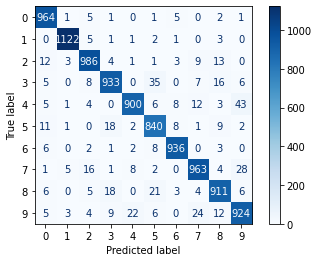

In [ ]:
RBF(best_num_centers,x_train_pca,y_train,y_train_raw,x_test_pca,y_test_raw, metrics=True)

As we can see, the model achieves really high accuaracy in both training and test sets. The fact that accuracy in the test set is just a bit lower than that in the training set shows that the model is able to generalize well and there isn't overfitting. \\
Apart from accuracy, the model also achieves high scores in the rest of the metrics examined such as recall, precision and f-measure for all classes. \\
From the confusion matrix, we can confirm that most samples are being classified correctly. The most common mistake is 4s classified as 9s with 43 misclassified examples. A simple way to deal with this would be by using techniques such as bagging or boosting.

# **Part 4:** RBF with KMeans-RLS hybrid training

As we saw in Part 2, it is hard to calculate the weights of the RBF model analytically when having a lot of samples in the training set. A way to tackle this problem is by using Recursive Least squares (RLS). This way no matrix inversion is needed and as a result, we can train a model with an even bigger number of kernels.

### Define model

In [ ]:
def RBF_RLS(num_centers, x_train, y_train, y_train_raw, x_test, y_test_raw, metrics=False):
    print("Number of centers: {}\n".format(num_centers))

    # Initial conditions for RLS
    l = 1e-3
    P = (1/l)*np.identity(num_centers) 
    w = np.zeros((num_centers,num_classes))

    #K-Means
    start = time.time()
    kmeans = KMeans(n_clusters=num_centers, init='k-means++', n_init=10, verbose=0).fit(x_train)
    end = time.time()
    KMeans_time = end-start
    print("K-Means elapsed time: {}s\n".format(KMeans_time))

    # Centers of the kernels
    centers = kmeans.cluster_centers_

    # Variance of each kernel
    dists = pdist(centers, metric='euclidean')
    d_max = np.amax(dists)
    var = d_max / tf.math.sqrt(2*float(centers.shape[0]))

    # Main loop of RLS
    start = time.time()
    for i in range(0,x_train_pca.shape[0]):
        phi = rbf_kernel(x_train[i].reshape(1,-1), Y=centers, gamma=np.float32(1/(2*var)))
        P = P - np.linalg.multi_dot([P,phi.T,phi,P])/(1+np.linalg.multi_dot([phi,P,phi.T]))
        g = np.dot(P,phi.T)
        a = y_train[i].reshape(-1,1) - np.dot(w.T,phi.T)
        w = w + np.dot(g,a.T)

    end = time.time()
    RLS_time = end-start
    print("RLS elapsed time: {}s\n".format(RLS_time))
    
    # Evaluate on test set
    x_test_kernel = rbf_kernel(x_test, Y=centers, gamma=np.float32(1/(2*var)))

    y_pred_test = np.dot(x_test_kernel,w)
    y_pred_test = np.argmax(y_pred_test, 1)

    print('Test set accuracy: ', accuracy_score(y_test_raw,y_pred_test))
    print('\n')
    
    if metrics is True:
        labels = [0,1,2,3,4,5,6,7,8,9]

        #Create and display confusion matrix
        M = confusion_matrix(y_test_raw, y_pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)

        disp.plot(cmap=plt.cm.Blues)
        plt.show

        #Accuracy, precision, recall and f1-score
        print(classification_report(y_test_raw, y_pred_test))
        
    return KMeans_time, RLS_time

### Train model for different number of kernels

We will examine how execution times for the KMeans and the RLS algorithms scale when increasing the number of kernels in the hidden layer. As we can see, with the RLS algorithm we are now able to train models with more than 2000 kernels in the hidden layer.

Number of centers: 100

K-Means elapsed time: 120.44158124923706s

RLS elapsed time: 58.14130449295044s

Test set accuracy:  0.8752


Number of centers: 200

K-Means elapsed time: 201.0084958076477s

RLS elapsed time: 80.79520297050476s

Test set accuracy:  0.9031


Number of centers: 500

K-Means elapsed time: 365.93237137794495s

RLS elapsed time: 185.80832409858704s

Test set accuracy:  0.9261


Number of centers: 1000

K-Means elapsed time: 629.8235528469086s

RLS elapsed time: 441.7418577671051s

Test set accuracy:  0.939


Number of centers: 1500

K-Means elapsed time: 843.5572745800018s

RLS elapsed time: 1096.7962400913239s

Test set accuracy:  0.9472


Number of centers: 2000

K-Means elapsed time: 1097.8375763893127s

RLS elapsed time: 2016.643099308014s

Test set accuracy:  0.945


Number of centers: 3000

K-Means elapsed time: 1544.9846181869507s

RLS elapsed time: 6365.7725558280945s

Test set accuracy:  0.9487




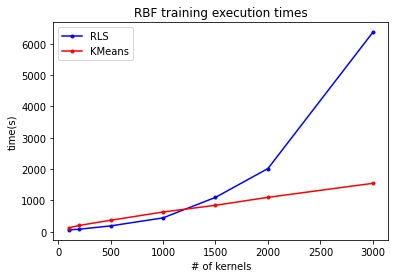

In [ ]:
num_centers = np.array([100,200,500,1000,1500,2000,3000])
RLS_times = []
K_Means_times = []

for center in num_centers:
    K_Means_time, RLS_time = RBF_RLS(center,x_train_pca,y_train,y_train_raw,x_test_pca,y_test_raw, metrics=False)
    K_Means_times.append(K_Means_time)
    RLS_times.append(RLS_time)
    
plt.plot(num_centers,RLS_times,'.-b',label='RLS')
plt.plot(num_centers,K_Means_times,'.-r',label='KMeans')
plt.xlabel('# of kernels')
plt.ylabel('time(s)')
plt.title('RBF training execution times')
plt.legend()
plt.show()


The first thing we notice is that increasing the number of kernels in the hidden layer causes the models to perform better. But that is true up to a certain number of kernels. We can see that for number of kernels between 1500 and 3000 the performance of the model on the test set is more or less the same. So, based on Occam's razor the best model to choose in this case would be the one with 1500 Gaussian kernels. \\
Moreover, regarding the training times, we can see that KMeans grows linearly with respect to the number of kernels while RLS grows in polynomial time. So, despite the fact that RLS allows us to train models with an even bigger number of kernels this is not optimal, both time-wise and performance-wise.

# **Part 5:** Class Imbalance

A common problem in many datasets is the existence of imbalanced classes. For example, in a dataset where the two classes are a normal transaction and a credit card fraud, it is obvious that we expect to have a lot more samples in the normal transaction class than in the fraud class. \\
Using common metrics such as accuracy to evaluate models trained in such datasets can often be misleading. So, usually other metrics are used such as the AUC of a ROC curve or weighted accuracy. \\
Another way to deal with this problem is by trying to create a balanced training set out of the original imbalanced one. This is usually done by undersampling the majority classes or oversampling the minority classes. \\
Moreover, synthetic samples can be used that may be created by GANs or algorithms such as SMOTE.

### Create the imbalanced set

In [ ]:
#Split set by classes
class_0, y0, y0_raw = x_train[y_train_raw == 0, :], y_train[y_train_raw == 0], y_train_raw[y_train_raw == 0]
class_1, y1, y1_raw = x_train[y_train_raw == 1, :], y_train[y_train_raw == 1], y_train_raw[y_train_raw == 1]
class_2, y2, y2_raw = x_train[y_train_raw == 2, :], y_train[y_train_raw == 2], y_train_raw[y_train_raw == 2]
class_3, y3, y3_raw = x_train[y_train_raw == 3, :], y_train[y_train_raw == 3], y_train_raw[y_train_raw == 3]
class_4, y4, y4_raw = x_train[y_train_raw == 4, :], y_train[y_train_raw == 4], y_train_raw[y_train_raw == 4]
class_5, y5, y5_raw = x_train[y_train_raw == 5, :], y_train[y_train_raw == 5], y_train_raw[y_train_raw == 5]
class_6, y6, y6_raw = x_train[y_train_raw == 6, :], y_train[y_train_raw == 6], y_train_raw[y_train_raw == 6]
class_7, y7, y7_raw = x_train[y_train_raw == 7, :], y_train[y_train_raw == 7], y_train_raw[y_train_raw == 7]
class_8, y8, y8_raw = x_train[y_train_raw == 8, :], y_train[y_train_raw == 8], y_train_raw[y_train_raw == 8]
class_9, y9, y9_raw = x_train[y_train_raw == 9, :], y_train[y_train_raw == 9], y_train_raw[y_train_raw == 9]

# Classes 0-4 have 500 samples each, classes 5-9 have 5000 samples each
class_0, y0, y0_raw = class_0[:500, :], y0[:500], y0_raw[:500]
class_1, y1, y1_raw = class_1[:500, :], y1[:500], y1_raw[:500]
class_2, y2, y2_raw = class_2[:500, :], y2[:500], y2_raw[:500]
class_3, y3, y3_raw = class_3[:500, :], y3[:500], y3_raw[:500]
class_4, y4, y4_raw = class_4[:500, :], y4[:500], y4_raw[:500]
class_5, y5, y5_raw = class_5[:5000, :], y5[:5000], y5_raw[:5000]
class_6, y6, y6_raw = class_6[:5000, :], y6[:5000], y6_raw[:5000]
class_7, y7, y7_raw = class_7[:5000, :], y7[:5000], y7_raw[:5000]
class_8, y8, y8_raw = class_8[:5000, :], y8[:5000], y8_raw[:5000]
class_9, y9, y9_raw = class_9[:5000, :], y9[:5000], y9_raw[:5000]

# Final imbalanced training set
x_train_imb = np.vstack((class_0, class_1, class_2, class_3, class_4, class_5, class_6, class_7, class_8, class_9))
y_train_imb = np.vstack((y0, y1, y2, y3, y4, y5, y6, y7, y8, y9))
y_train_raw_imb = np.hstack((y0_raw, y1_raw, y2_raw, y3_raw, y4_raw, y5_raw, y6_raw, y7_raw, y8_raw, y9_raw))

print("Training set shape", x_train_imb.shape, y_train_imb.shape)
print("Testing set shape", x_test.shape, y_test.shape)

Training set shape (27500, 784) (27500, 10)
Testing set shape (10000, 784) (10000, 10)


### Dimensionality reduction using PCA

In [ ]:
start = time.time()

pca = PCA(n_components=0.9).fit(x_train_imb)
x_train_pca_imb = pca.transform(x_train_imb)
x_test_pca = pca.transform(x_test)

end = time.time()
print("PCA elapsed time: {}s\n".format(end-start))
print("We extract {} feautures from the original {}.".format(x_train_pca_imb.shape[1],x_train_imb.shape[1]))
print('Cumulative explained variation for {} principal components: {}'.format(x_train_pca_imb.shape[1], np.sum(pca.explained_variance_ratio_)))

PCA elapsed time: 3.3746306896209717s

We extract 89 feautures from the original 784.
Cumulative explained variation for 89 principal components: 0.9004039168357849


We can see that now 89 principal components are needed to explain 90% of the variance instead of 87 that we had previously. That is probably due to the imbalance of the classes that makes it more difficult to capture the information that they hold by using less features.

### Train RBF on the imbalanced dataset

Number of centers: 2000

KMeans elapsed time: 512.378427028656s
Transforming training data: 3.5466628074645996s
Calculating weights: 259.18089985847473s
Testing elapsed time: 1.6935193538665771s

Training set accuracy:  0.9592
Test set accuracy:  0.8996


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       980
           1       0.99      0.96      0.97      1135
           2       0.97      0.86      0.91      1032
           3       0.97      0.72      0.83      1010
           4       0.99      0.71      0.83       982
           5       0.80      0.96      0.88       892
           6       0.94      0.99      0.96       958
           7       0.90      0.95      0.92      1028
           8       0.82      0.95      0.88       974
           9       0.78      0.95      0.85      1009

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0

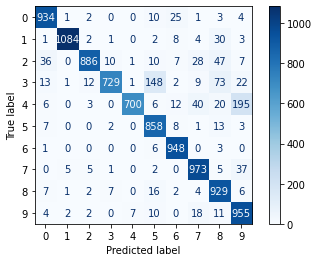

In [ ]:
# Train model
RBF(2000, x_train_pca_imb, y_train_imb, y_train_raw_imb, x_test_pca, y_test_raw, metrics=True)

As we can see, the model achieves pretty high accuracy on the training set but falls behind when evaluated on the test set. More specifically, the model seems to struggle when having to classify 3s or 4s leading to a smaller recall metric for these classes. From the confusion matrix we see that many 3s are classified as 5s and many 4s as 9s. This doesn't seem strange seem 3 and 4 are two of the minority classes that we have and 5 and 9 two of the majority classes.

### SMOTE algorithm

In order to make the original dataset balanced we will apply the SMOTE algorithm. \\
SMOTE creates synthetic data for the minority classes so that in the end all classes are balanced. This way, the model trained will not be biased towards the majority classes. \\
In SMOTE, a synthetic sample is created by taking a sample from the minority class, finding a neighbor of its in the feature space and then creating a new sample whose features lie in the line that connects these samples. \\
The advantage of using synthetic samples over oversampling existing ones is that the model trained on that set has better generalization strength. 

In [ ]:
# Apply SMOTE
sm = SMOTE(k_neighbors=5)

x_train_res, y_train_raw_res = sm.fit_resample(x_train_imb,y_train_raw_imb)
print(x_train_imb.shape, y_train_raw_imb.shape)
print(x_train_res.shape, y_train_raw_res.shape)

# One-hot encoding
y_train_res = np_utils.to_categorical(y_train_raw_res, num_classes)

(27500, 784) (27500,)
(50000, 784) (50000,)


### Dimensionality reduction using PCA

In [ ]:
start = time.time()

pca = PCA(n_components=0.9).fit(x_train_res)
x_train_pca_res = pca.transform(x_train_res)
x_test_pca = pca.transform(x_test)

end = time.time()
print("PCA elapsed time: {}s\n".format(end-start))
print("We extract {} feautures from the original {}.".format(x_train_pca_res.shape[1],x_train_res.shape[1]))
print('Cumulative explained variation for {} principal components: {}'.format(x_train_pca_res.shape[1], np.sum(pca.explained_variance_ratio_)))

PCA elapsed time: 5.739652633666992s

We extract 79 feautures from the original 784.
Cumulative explained variation for 79 principal components: 0.9010488390922546


Now that the classes are balanced we need 79 (10 less than before) principal components to explain 90% of the variance of the initial data.

### Train RBF on the new balanced dataset

Number of centers: 2000

KMeans elapsed time: 1011.5351858139038s
Transforming training data: 6.150159120559692s
Calculating weights: 542.4904229640961s
Testing elapsed time: 1.6928927898406982s

Training set accuracy:  0.97334
Test set accuracy:  0.9113


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       980
           1       0.98      0.98      0.98      1135
           2       0.98      0.89      0.93      1032
           3       0.98      0.73      0.83      1010
           4       0.96      0.81      0.88       982
           5       0.80      0.97      0.88       892
           6       0.94      0.99      0.96       958
           7       0.93      0.94      0.93      1028
           8       0.84      0.94      0.89       974
           9       0.80      0.93      0.86      1009

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      

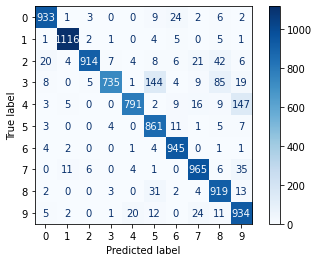

In [ ]:
# Retrain model
RBF(2000, x_train_pca_res, y_train_res, y_train_raw_res, x_test_pca, y_test_raw, metrics=True)

After making the dataset balanced by adding the synthtic data, we can see that the model has increased performance on both the training and the test set. We can see that the problem we mentioned above with the 3s and the 4s hasn't been completely dealt with, however, we keep the fact that the overall performance has increased.